In [3]:
# Fill in your names using the format below
your_name_1 = "Booy, Harm"
your_name_2 = "Dongen, Summer van"
your_name_3 = "Groen, Maud"
your_name_4 = "Wasser, Jeroen"
your_name_5 = "Hugten, Koen van"

# Data Mining: Assignment 2

In this assignment you are asked to build convolutional neural networks for two quite different image datasets.

To complete this assignment, you must submit _all_ your work, including the trained models (because we need to be able to test them). You will need to upload a zip file to Canvas with:
* This notebook, containing ALL your code
* A PDF report, including a download link to all other files (e.g. the trained models). Keep the report under 10 pages.

For the report you can use any text editor, but export it to PDF. The report should explain all your design decisions, answers to the questions below, analyses of your models, and a clear interpretation of your results. Make the report self-contained, and copy all necessary plots from this notebook to your report. 

To submit the other files (e.g. the stored models), you can put them in a GitHub repository and reference the link in your report. Alternatively, you can submit them as a large zipped file in another way, as long as a download link is in the report.



In [4]:
# Imports and version checking
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
from packaging import version

sklearn_version = sklearn.__version__
tensorflow_version = tf.__version__
if version.parse(tensorflow_version) < version.parse("2.2.0"):
    print("Tensorflow is outdated. This is version {}. Please update to 2.2 or later (e.g. 2.4)".format(tensorflow_version))
elif version.parse(tensorflow_version) < version.parse("2.4.0"):
    print("Tensorflow version is <2.4. This will likely work but we recommend updating to 2.4".format(tensorflow_version))
else:
    print("Looks good. You may continue :)")

Looks good. You may continue :)


### Storing and submitting files

The evaluation functions used in this notebook will automatically store models for you. Be sure to submit all .h5 and .p files, as well as any .json files created (these are created only for large models).

If you want to run and solve the notebook on your local machine/laptop, fill in the path 'base_dir' to your assignment folder into the next cell.

If you use Colab, we recommend that you link it to your Google Drive by uncommenting the code below.  
* Create an 'assignment' folder in your Google Drive with this notebook 
* Uncomment and run the code below to give permissions to store the model files
* Fill in the path to your assignment folder below
  * It's likely `base_dir = '/content/drive/My Drive/assignment'`

In [5]:
# For storing the files in a local folder.
base_dir = 'C:/Users/20182440/Documents/5.1/Data Mining/Assignment 2'

# Uncomment the following line to run in Google Colab.
# This will link the notebook to your Google drive to store your models and cache the dataset.
# This will ask you to authenticate and give permissions.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
base_dir = '/content/drive/My Drive/Colab Notebooks'

Mounted at /content/drive


### Using GPUs
While you can solve this assignment on a CPU, using a GPU will speed up training a lot. If you have a local GPU, you can use that. If you don't, we recommend Google Colab. When you are in Colab:
* In Runtime > Change runtime type, select the GPU under Hardware Accelerator
* Run the 4th cell on the top of this notebook to check that the GPU is found.

Note that the free version of Colab may not always have GPUs ready all the time, and may deny you a GPU when you have used them a lot. When you are temporarily 'locked out', you can switch to a non-GPU runtime or to a local instance of Jupyter running on your machine. Take this into account in your planning, so that you don't do all your training at the last moment and are locked out right before the deadline.

In [6]:
# Uncomment the following to check whether you have access to a GPU in Google Colab
tf.config.experimental.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Grading
Grading is based on the following aspects:
* Correctness in answering the questions. Carefully read the questions and answer what is asked for. Train your models on the correct data. It should be clear on which data should be trained, but ask when in doubt. When something is not defined (e.g. the number of epochs or batch size), you can freely choose them.
* Clarity of your explanations. Write short but precise descriptions of what you did and why. Give short but clear explanations of the observed performance. After your explanation, your approach and model should make perfect sense. 
* Part of your grade depends on how well your models perform. The top grade is awarded to the best model in class. You don't need to invest lots of effort into the last tiny improvement, though. Unless specified, we look at the accuracy on the validation set. If your learning curves are very erratic we'll compute a score based on the smoothed curves (i.e. single peaks don't count).
* The weight of each question is indicated. Take this into account when planning your time.

### Other tips
* Start now. Don't wait until the last minute to do the assignment. The models take time to train, most questions will require some thinking, and some require you to read up on some new concepts.
* Don't train for more than 100 epochs, i.e. don't throw excessing computational resources at the problem. If your model hasn't converged by then, think of ways it could be made to converge faster. In this assignment you are not after the last tiny improvement, you can stop when learning curves flatten out. Do at least 5 epochs to get a reasonable learning curve.
* Take care that you upload the results as requested. You need to submit not only the notebook but also the trained models.
* The dataset we will use is quite large and can take a while to download and cache for the first time, especially if you have limited RAM on your local device (laptop). Once cached, it should load fast.
* We provide an evaluation function that also stored models to disk. After you are done training the model, set the 'train' attribute to False so that the model doesn't train again (and loads from file instead) when you restart and rerun your notebook.
* Explore. For many questions we'll ask you to explain your model design decisions. You cannot magically know the best solutions but you can experiment
based on your understanding and make decisions based on both your knowledge and experiments. Your explanation is at least as important as the performance of your model. Don't say 'I tried every possible option and this is the best I found', but rather 'I tried X because I think that Y' and then interpret the results and what you learned from them'.
* **Be original. We will check for plagiarism between student submissions.**

### Data

For this assigment we will use a few [Tensorflow Datasets](https://www.tensorflow.org/datasets). We selected the following datasets:
* [rock_paper_scissors](https://www.tensorflow.org/datasets/catalog/rock_paper_scissors) which includes images of hands playing rock, paper and scissor game. Each image is of shape (300, 300, 3) and the dataset contains 2520 training and 372 testing images. You can explore the images from this dataset at [this link](https://knowyourdata-tfds.withgoogle.com/#tab=STATS&dataset=rock_paper_scissors).
* [tf_flowers](https://www.tensorflow.org/datasets/catalog/tf_flowers) which includes images of 5 kinds of flowers (daisy, tulips, dandelions, roses, sunflowers) in a variety of settings. The images have different shapes, mostly around (260, 260, 3) and the dataset contains 3670 images. You can explore the images from this dataset at [this link](https://knowyourdata-tfds.withgoogle.com/#tab=STATS&dataset=tf_flowers).

In [7]:
import tensorflow_datasets as tfds

rock_train, rock_test = tfds.load(
    'rock_paper_scissors',
    split=['train', 'test'],
    shuffle_files=False,
)
flower_train, flower_test = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=False,
)

#### Image preprocessing

We need to resize the images to fit the RAM memory provided by Google Colab. We reshape each dataset entry from (300, 300, 3) to (160, 160, 3). The `IMG_SIZE = 160` is chosen to be compatible with the trained weights of the model used for transfer learning at the end of the assigment. The value of each pixel is converted from [0, 255] range to [0, 1] range.

In [8]:
IMG_SIZE  = 160
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

def process_img(sample):
  sample['image'] = tf.cast(sample['image'], tf.float32)
  sample['image'] = sample['image'] / 255.
  sample['image'] = tf.image.resize(sample['image'], [IMG_SIZE, IMG_SIZE])
  return sample

rock_train = rock_train.map(process_img)
rock_test  = rock_test.map(process_img)
flower_train = flower_train.map(process_img)
flower_test  = flower_test.map(process_img)

We randomly split the training dataset into 90% (X_train, y_train) and 10% (X_valid, y_valid). We also need to extract the labels from the data points since they are stored jointly. This yields training, validation, and test sets for both datasets.

In [9]:
# Don't change the name of these variables

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split 

# Preprocesses and splits data into train, validation, and test splits
def split_data(train,test):

  # Converts TF objects to (X, y) data
  def numpy_convert(data, type):
    data_np = np.vstack(list(tfds.as_numpy(data)))
    return np.array(list(map(lambda x: x[0][type], data_np)))

  X_train_all = numpy_convert(train,'image')
  y_train_all = to_categorical(numpy_convert(train,'label'))
  X_train, X_valid, y_train, y_valid = train_test_split(X_train_all, y_train_all, stratify=y_train_all, 
                                                        train_size=0.9, test_size=0.1, random_state=1)
  X_test = numpy_convert(test,'image')
  y_test = to_categorical(numpy_convert(test,'label'))
  return X_train, X_valid, X_test, y_train, y_valid, y_test

Xr_train, Xr_valid, Xr_test, yr_train, yr_valid, yr_test = split_data(rock_train, rock_test)
Xf_train, Xf_valid, Xf_test, yf_train, yf_valid, yf_test = split_data(flower_train, flower_test)

class_names_r = ["rock", "paper", "scissors"]
class_names_f = ["dandelion", "daisy", "tulips", "sunflowers", "roses"]

Check the formatting - and what the data looks like

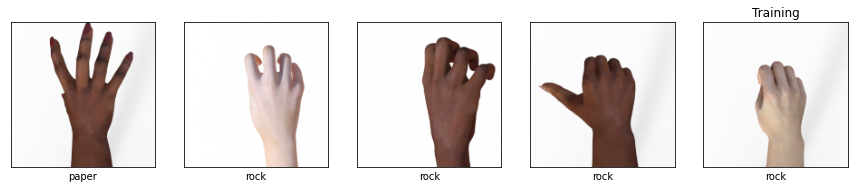

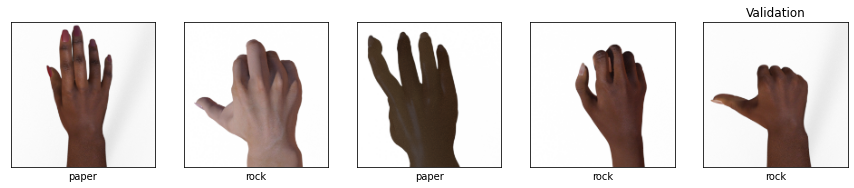

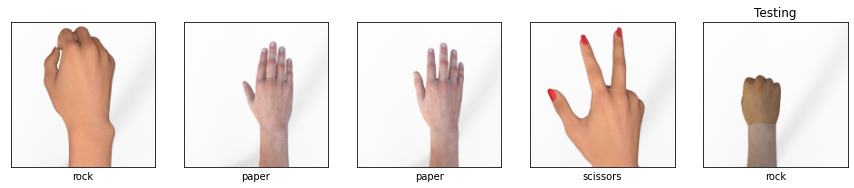

In [10]:
from random import randint

# Takes a list of row ids, and plots the corresponding images
# Use grayscale=True for plotting grayscale images
def plot_images(X, y, class_names, randomize= True, title = None):
    if randomize:
      images = [randint(0,len(X) - 1) for i in range(5)]
      X = [X[i] for i in images]
      y = [y[i] for i in images]
    fig, axes = plt.subplots(1, len(X),  figsize=(15,30))
    if title:
      plt.title(title)
    for n in range(len(X)):
        axes[n].imshow(X[n])
        axes[n].set_xlabel(class_names[np.argmax(y[n])])
        axes[n].set_xticks(()), axes[n].set_yticks(())
    plt.show()

plot_images(Xr_train, yr_train, class_names_r, title = "Training")
plot_images(Xr_valid, yr_valid, class_names_r, title = "Validation")
plot_images(Xr_test, yr_test, class_names_r, title = "Testing")

In [11]:
print("Xr_train shape:", Xr_train.shape)
print("Xr_valid shape:", Xr_valid.shape)
print("Xr_test shape:", Xr_test.shape)

Xr_train shape: (2268, 160, 160, 3)
Xr_valid shape: (252, 160, 160, 3)
Xr_test shape: (372, 160, 160, 3)


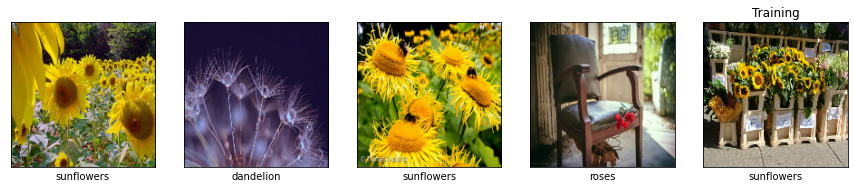

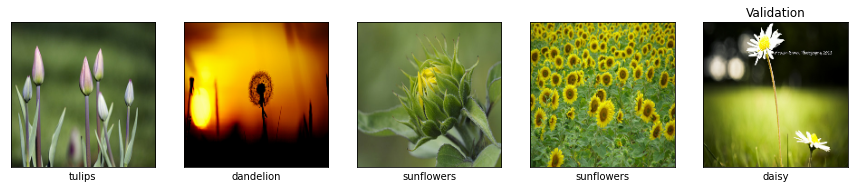

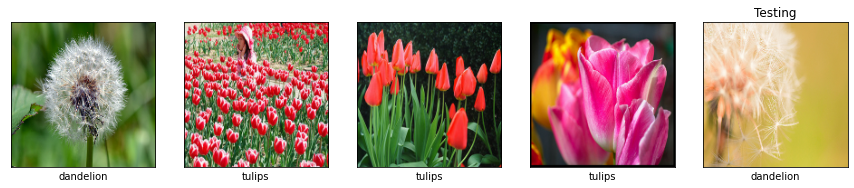

In [12]:
plot_images(Xf_train, yf_train, class_names_f, title = "Training")
plot_images(Xf_valid, yf_valid, class_names_f, title = "Validation")
plot_images(Xf_test, yf_test, class_names_f, title = "Testing")

### Evaluation harness
We provide an evaluation function 'run_evaluation' that you should use to 
evaluate all your models. It also stores the trained models to disk, to avoid having to train
them over and over again. Your last run of the evaluation function (the last one
stored to file), is the one that will be evaluated. The 'train' argument indicates whether to train or to load from disk. We have provided helper functions for saving and loading models to/from file, assuming you use TensorFlow. If you use PyTorch you'll have to adapt them.

In [13]:
# Set this to True to render and verify this notebook without retraining all the deep learning models.
# All models will be loaded from file instead.
stop_training = False

In [14]:
import os
import pickle
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model # for use with tensorflow
from tensorflow.keras.models import model_from_json
import pydot
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import inspect
from IPython.core import page
page.page = print

# Helper function for user feedback
def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')
        
# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

# Helper function to format answers
def print_answer(ans):
    output = ""
    for line in ans.splitlines()[0:]:
        output += line.strip() + " "
    output += "(length: "+str(len(output))+")\n"
    print(output)
    

def load_model_from_file(base_dir, name, extension='.h5'):
    """ Loads a model from a file. The returned model must have a 'fit' and 'summary'
    function following the Keras API. Don't change if you use TensorFlow. Otherwise,
    adapt as needed. 
    Keyword arguments:
    base_dir -- Directory where the models are stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
    """
    try:
        # if a json description is available, load config and then weights
        if os.path.isfile(os.path.join(base_dir, name+'.json')):
            json_file = open(os.path.join(base_dir, name+'.json'), 'r')
            loaded_model_json = json_file.read()
            json_file.close()
            model = model_from_json(loaded_model_json)
            model.load_weights(os.path.join(base_dir, name+extension))
        # else just load the entire model from hdf5 file
        else:
            model = load_model(os.path.join(base_dir, name+extension))
    except OSError:
        shout("Saved model could not be found. Was it trained and stored correctly? Is the base_dir correct?")
        return False
    return model

def save_model_to_file(model, base_dir, name, extension='.h5'):
    """ Saves a model to file. Don't change if you use TensorFlow. Otherwise,
    adapt as needed.
    Keyword arguments:
    model -- the model to be saved
    base_dir -- Directory where the models should be stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
    """
    path = os.path.join(base_dir, name+extension)
    model.save(path)
    size = os.path.getsize(path)
    # If model > 100MB, store the weights and architecture only.
    if size > 100*1024*1024:
        print("Model larger than 100MB, storing weights only.")
        model.save_weights(path)
        model_json = model.to_json()
        with open(os.path.join(base_dir, name+".json"), "w") as json_file:
            json_file.write(model_json)

# Evaluation harness
def run_evaluation(name, model_builder, data, base_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, print_model=True, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data is given as a generator or not. Set batch size to None when using a generator.
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with. Set batch size to None when using a generator.
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    print_model -- whether or not to print the model
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}

    if train and not stop_training: # Train anew
        shout("Training the model", verbose)
        if generator:
            generator, X_val, y_val = data
            history = model.fit(generator, epochs=epochs, batch_size=batch_size,
                              steps_per_epoch=steps_per_epoch, verbose=1, 
                              validation_data=(X_val, y_val))
            learning_curves = history.history
        else:
            X_train, X_val, y_train, y_val = data
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              verbose=1, validation_data=(X_val, y_val))
            learning_curves = history.history
        shout("Saving to file", verbose)
        save_model_to_file(model, base_dir, name)
        with open(os.path.join(base_dir, name+'.p'), 'wb') as file_pi:
            pickle.dump(learning_curves, file_pi)
        shout("Model stored in "+base_dir, verbose)
    else: # Load from file
        model = load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
    # Report
    lc = pd.DataFrame(learning_curves)
    print("Max val score: {:.2f}%".format(lc.iloc[:,3].max()*100))
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    plt.show()
    
    if print_model:
        print(model.summary())
    plot_model(model, to_file=os.path.join(base_dir,name+'.png'))

## Part 1. Convolutional neural networks (30 points)
### Question 1.1: Design a ConvNet (15 points)
- Build a sequential convolutional neural network to distinguish the classes of hand gestures and flowers. It's best to do this by implementing a function that builds and returns the model (see the example above).
- You can build two entirely different models for both datasets.
- Try to achieve the best validation accuracy you can. You can use any depth, any combination of layers, and any kind of regularization and tuning. You can use different batch sizes and number of epochs. Think carefully about all design decisions.
- Beware that you don't overfit on the validation set. You can occasionally test on the test set to see if you get a similar score, but don't tune on the test set.
- In your report provide a description of your final model (you can include screenshots) and clearly expolain all your design choices: explain what you did and also why. Also discuss the performance of the model. Is it working well? Did other models work much worse? Both the performance of the model and your explanations matter.
- Explictly explore different filter sizes and padding techniques. Explain what the effect is, also in relationship with the layer input sizes.
- Explain the differences between both models (for hand gestures and flowers). How did the dataset influence your decisions? What works better on one dataset but not on the other?
- The report and code (in this notebook) will count for 10 points, and model performance for 5 points. 
- We will look at the correctness and cleanliness of the code. If we cannot understand the code, this may hurt your grade.

**NOTE:** The training might be noisy and unstable. The training dataset is quite small, with a lot of variety in the data (e.g. different positions of the hand, skin color, left and right hand,...). For this exercise, we will not use any data augmentation, so avoiding overfitting is quite hard. However, you are expected to tackle the overfitting by layer regularization, dropout layers, learning rate tuning and more.

Training the model
Epoch 1/10
71/71 [==============================] - 14s 58ms/step - loss: 0.1344 - accuracy: 0.9524 - val_loss: 3.7005 - val_accuracy: 0.3333
Epoch 2/10
71/71 [==============================] - 3s 42ms/step - loss: 0.0234 - accuracy: 0.9943 - val_loss: 12.1245 - val_accuracy: 0.3333
Epoch 3/10
71/71 [==============================] - 3s 42ms/step - loss: 0.0137 - accuracy: 0.9956 - val_loss: 16.1148 - val_accuracy: 0.3333
Epoch 4/10
71/71 [==============================] - 3s 49ms/step - loss: 0.0031 - accuracy: 0.9996 - val_loss: 27.1844 - val_accuracy: 0.3333
Epoch 5/10
71/71 [==============================] - 3s 45ms/step - loss: 0.0026 - accuracy: 0.9996 - val_loss: 10.8155 - val_accuracy: 0.3373
Epoch 6/10
71/71 [==============================] - 3s 42ms/step - loss: 6.7614e-04 - accuracy: 1.0000 - val_loss: 1.6684 - val_accuracy: 0.5754
Epoch 7/10
71/71 [==============================] - 3s 42ms/step - loss: 0.0012 - accuracy: 0.9996 - val_loss: 0.0887 - val_ac

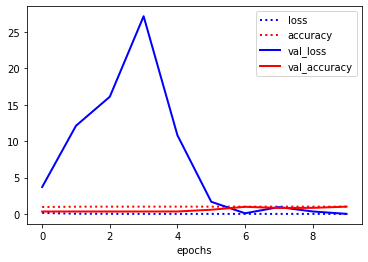

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 160, 160, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 160, 160, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 80, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 80, 80, 64)       256       
 hNormalization)                                                 
                                                        

In [15]:
from tensorflow.keras import models
from tensorflow.keras import layers 
from tensorflow.keras.utils import to_categorical


def build_convnetmodel_hand():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=IMG_SHAPE))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2), strides=2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2), strides=2))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2), strides=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(3, activation='softmax'))
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



eval_split_r = Xr_train, Xr_valid, yr_train, yr_valid



run_evaluation("model_1_rock", build_convnetmodel_hand, eval_split_r, base_dir, train=True, epochs=8, batch_size=32)



Training the model
Epoch 1/15
83/83 [==============================] - 8s 77ms/step - loss: 1.5738 - accuracy: 0.3868 - val_loss: 2.0615 - val_accuracy: 0.3707
Epoch 2/15
83/83 [==============================] - 5s 63ms/step - loss: 1.2600 - accuracy: 0.5004 - val_loss: 2.3950 - val_accuracy: 0.3776
Epoch 3/15
83/83 [==============================] - 5s 63ms/step - loss: 1.1214 - accuracy: 0.5553 - val_loss: 1.4125 - val_accuracy: 0.5170
Epoch 4/15
83/83 [==============================] - 5s 63ms/step - loss: 0.9971 - accuracy: 0.6207 - val_loss: 1.1092 - val_accuracy: 0.6088
Epoch 5/15
83/83 [==============================] - 5s 63ms/step - loss: 0.8225 - accuracy: 0.6866 - val_loss: 0.9242 - val_accuracy: 0.6497
Epoch 6/15
83/83 [==============================] - 5s 63ms/step - loss: 0.6669 - accuracy: 0.7642 - val_loss: 1.4223 - val_accuracy: 0.5034
Epoch 7/15
83/83 [==============================] - 5s 63ms/step - loss: 0.5018 - accuracy: 0.8312 - val_loss: 1.2530 - val_accuracy: 0

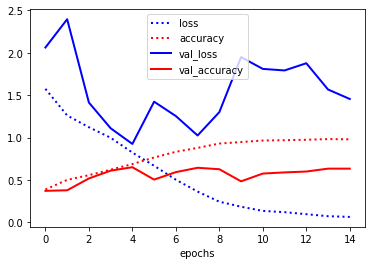

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 160, 160, 32)      896       
                                                                 
 conv2d_4 (Conv2D)           (None, 160, 160, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 80, 80, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 80, 80, 64)        18496     
                                                                 
 conv2d_6 (Conv2D)           (None, 80, 80, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 40, 40, 64)       0         
 2D)                                                  

In [16]:
def build_convnetmodel_flower():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=IMG_SHAPE))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='softmax'))
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

eval_split_f = Xf_train, Xf_valid, yf_train, yf_valid

run_evaluation("model_1_flower", build_convnetmodel_flower, eval_split_f, base_dir, train=True, epochs=15, batch_size=32)

### Question 1.2: Data Augmentation (15 points)

- Augment the preprocessed training data. You can explore using image shifts, rotations, zooming, flips, color augmentation etc. What works well, and what does not? Reason about what might work or not on these images and also verify it through experimentation.
- Implement the generator in a function `augment_data` that returns a generator and the validation set
- Evaluate the model with the augmented data using the 'run_evaluation' function (see the example below).
- In your report, add a clear explanation of your design choices for augmentation techniques.  Also discuss the performance of the model. Did augmentation help?
- Did you find that different augmentations help for the two different datasets?
- The report and code will count for 10 points, and model performance for 5 points. Again, correctness and cleanliness of the code matter.

In [17]:
# Note that we build the same untrained model as in question 1.1 but store the 
# trained version as model_1_2. Change attributes as needed to run on augmented
# data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def augment_data(X_train, y_train, X_valid, y_valid):
  """ Augments the data and returns a generator and the validation data and labels
  """
  # Boilerplate code. You can change this however you like.
  generator = ImageDataGenerator().flow(X_train, y_train)
  return generator, X_valid, y_valid

def augment_data_rock():
  return augment_data(Xr_train, yr_train, Xr_valid, yr_valid)

# Batch size should be None since we are using a generator.
# You can add a steps_per_epoch parameter if you like
run_evaluation("model_2_rock", build_toy_model, augment_data_rock(), base_dir, 
               train=True, generator=True, epochs=3, batch_size=None)

NameError: ignored

## Part 2. Model evaluation (25 points)
### Question 2.1: Accuracy on the testing set (5 points)

Load the last trained model (e.g. `model_2_rock` in the example above) and use it to predict the classes for the test set. Compute the accuracy based on the test set.
- Discuss the observed performance. Is it what you expected? Is your model under- or overfitting?
- 2 points will be given for your discussion, 3 for the test set performance.

### Question 2.2: Analyze errors (20 points)

* Plot the confusion matrix and discuss which classes are often confused.
* Analyze the misclassifications in more depth by visualizing which kinds of mistakes are made for each class. Plot 5 examples of misclassifications for each class and interpret them. For instance, are the errors related to the background, noisiness, etc.? Repeat for both datasets.
* Interpret the results and summarize your findings in your report. Focus on explaining why certain images are misclassified. Are they somehow harder or has your model not learned to recognize some occurences in the images? Keep in mind that there can be images which are quite similar in the dataset. Do you notice different kinds of misclassifications between the two datasets (e.g. what is the effect of not having a white background)?

**Note:** If, for some classes, you cannot find 5 misclassifications, simply plot all misclassifications for that class.

## Part 3. Transfer learning (45 points)
### Question 3.1 Transfer learning from MobileNet (25 points)

- Import the MobileNetV2 model, pretrained on ImageNet. [See here](https://keras.io/applications/). Only import the convolutional part, not the dense layers.
- Build a model that adds at least one dense hidden layer and output layer to the convolutional base, and freezes the convolutional base. Add [Global Average Pooling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) after the convolutional base, right before the dense layer(s). 
- Consider unfreezing the last few convolutional layers, in a systematic way, and evaluate whether that works better. You can also consider adding multiple dense hidden layers and regularization layers.
- Train the resulting model on the augmented training data and report the model and score.
- Explain all your design decisions clearly in your report. Do you need a different approach for the two datasets (e.g. different amounts of finetuning)?
- Explore [other pretrained models](https://keras.io/api/applications/). Can you get better performance? Do keep in mind that many will be too large to run in Google Colab. 
- The report and code will count for 20 points, and model performance for 5 points. 


### Question 3.2: Visualizing the learned embeddings with tSNE (20 points)

Extract the learned embeddings of the training images using your pretrained model and plot them on a 2D map using [tSNE](https://lvdmaaten.github.io/tsne/) as the dimensionality reduction technique.

- Extract the embeddings based on the (finetuned) convolutional part of your models (e.g. MobileNetV2 generates 1280-sized embeddings). The embeddings are the output of the GlobalAveragePooling layer.
- Applies scikit-learn's implementation of [tSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to reduce the size of the embeddings from 1280 to 2 (e.g for MobileNetV2 this will mean `original_array` of  size (num_images, 1280) compressed to a reduced array of size (num_images, 2)).
- Scatterplot the 2D vectors on a map highlighting the formed clusters, and color-coded by the true labels.
- Interpret the 2D TSNE map in terms of the formed clusters. Discuss the performance of the transfer learning model in your report. Does the learned embedding clearly separate the different classes, and can you also see this in the 2D-plot (e.g. do they cluster together)?
- Include the plot and your clear explanations in your report.

### Bonus question (+5 points)
Use some of the model interpretation techniques we saw in class, e.g. plotting the filter activations or drawing class activation maps. Interpret the results. Are your models indeed learning what they are supposed to learn?

### Have fun!